# **Setup and Load Data**

# Install dependecies and setup
Tensorflow for pipelining, opencv for cleaning dataset, matplotlib for visualization

In [80]:

%pip install tensorflow tensorflow-gpu opencv-python matplotlib 

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tensorflow in .\venv\lib\site-packages (2.10.0)



You should consider upgrading via the 'd:\project\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Validation

In [81]:
%pip list

Package                      Version
---------------------------- -----------
absl-py                      1.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.8
astunparse                   1.6.3
attrs                        22.1.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
cachetools                   5.2.0
certifi                      2022.6.15.1
cffi                         1.15.1
charset-normalizer           2.1.1
colorama                     0.4.5
cycler                       0.11.0
debugpy                      1.6.3
decorator                    5.1.1
defusedxml                   0.7.1
entrypoints                  0.4
executing                    1.0.0
fastjsonschema               2.16.1
flatbuffers                  2.0.7
fonttools                    4.37.1
gast                         0.4.0
google-auth                  2.11.0
google-auth-oauthlib         0.4.6

You should consider upgrading via the 'd:\project\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Importing dependecies

In [82]:
import tensorflow as tf
import os 
#navigate through file structures
from tensorflow import keras
from keras import layers

Limiting gpu vrm usage 

In [83]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [84]:
os.chdir('D:\\project')
data_dir = 'trainData'

In [85]:
os.listdir(data_dir)

['banana', 'mold', 'over_ripe', 'ripe', 'rotten', 'unripe']

Sorting, Pipelining and Loading Data

In [86]:
import numpy as np
from matplotlib import pyplot as plt

Building data pipeline

In [87]:
data = tf.keras.utils.image_dataset_from_directory('trainData')

Found 5264 files belonging to 6 classes.


For accessing the pipeline, data visualization, using batchs

In [88]:
data_iterator = data.as_numpy_iterator()

In [89]:
batch = data_iterator.next()

In [90]:
# Images represented as numpy arrays
batch

(array([[[[ 71.71875 ,  60.71875 ,  40.71875 ],
          [ 74.140625,  63.140625,  43.140625],
          [ 75.09375 ,  64.09375 ,  44.09375 ],
          ...,
          [119.296875,  96.0625  ,  66.890625],
          [120.78125 ,  93.25    ,  70.046875],
          [116.765625,  88.015625,  67.265625]],
 
         [[ 73.421875,  62.421875,  42.421875],
          [ 71.75    ,  60.75    ,  40.75    ],
          [ 73.21875 ,  62.21875 ,  42.21875 ],
          ...,
          [105.765625,  87.03125 ,  59.3125  ],
          [ 99.984375,  78.71875 ,  55.078125],
          [ 95.125   ,  70.734375,  50.90625 ]],
 
         [[ 72.4375  ,  61.4375  ,  41.4375  ],
          [ 73.8125  ,  62.8125  ,  42.8125  ],
          [ 73.8125  ,  62.8125  ,  42.8125  ],
          ...,
          [ 77.640625,  62.90625 ,  38.6875  ],
          [ 69.90625 ,  54.65625 ,  32.53125 ],
          [ 66.71875 ,  49.46875 ,  30.3125  ]],
 
         ...,
 
         [[132.      , 135.      , 116.      ],
          [132.   

In [91]:
len(batch)
#images, labels

2

In [92]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [93]:

batch[1]

array([0, 5, 5, 4, 4, 3, 3, 3, 0, 0, 0, 5, 3, 4, 0, 0, 0, 5, 3, 0, 0, 0,
       1, 3, 5, 4, 0, 5, 0, 5, 0, 2])

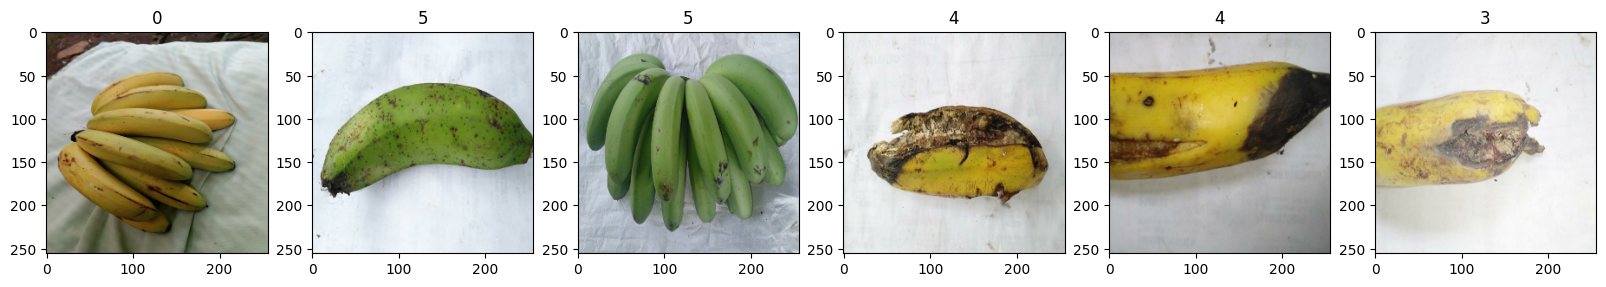

In [94]:
#checking which class is assign to which type of image

fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Pre-processing

In [95]:
#lowest value
batch[0].min()

0.0

In [96]:
#highest value
batch[0].max()

255.0

Optimizing by reducing values to btwn 0-
Scaling Data

In [97]:
scaled = batch[0] / 255

In [98]:
scaled.min()

0.0

In [99]:
scaled.max()

1.0

In [100]:
# x = Images, y = target variable
# no transformation on y 
# mapping acrosss elements in the dataset 
data = data.map(lambda x,y: (x/255, y))

In [101]:
scaled_iterator = data.as_numpy_iterator()

In [102]:
batch = scaled_iterator.next()

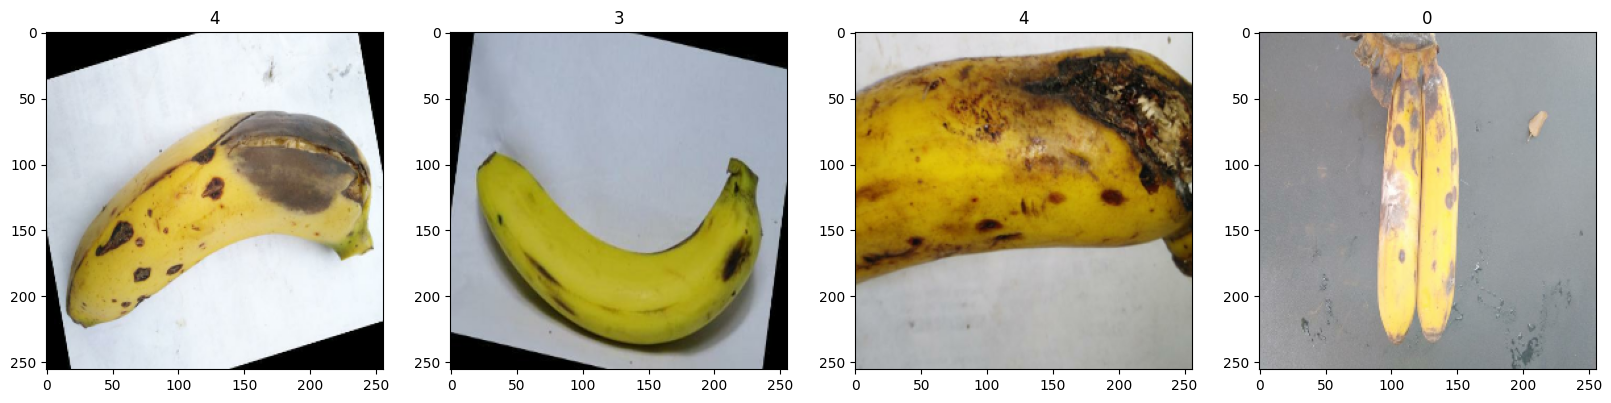

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data

In [104]:
len(data)

165

In [109]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [106]:
train_size

115

In [110]:
val_size

34

In [108]:
test_size

16

In [111]:
train_size+val_size+test_size

165

Batch allocation

In [112]:
train = data.take(train_size)
#skiping batches already taken 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [115]:
len(val)
# train, test too

34